In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

In [2]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(len(pairwise)):
        results.append(np.roll(pairwise[i], -i))
    return np.roll(np.mean(results, 0), len(pairwise)//2)

In [3]:
def proj(a, b):
    b_normalized = b / np.linalg.norm(b, axis=1, keepdims=True)
    return a - b_normalized * np.diag(np.tensordot(a, b_normalized, [1, 1]))[:, None]


In [4]:
def pairwise_cos_sim_centered(x):
    return pairwise_cos_sim(x - np.mean(x, axis=0, keepdims=True))

def pairwise_dot(x):
    return x @ x.transpose()

def pairwise_cos_sim(x):
    x_normalized = x / np.linalg.norm(x, axis=-1, keepdims=True)
    return x_normalized @ x_normalized.transpose()

# Parameters and Initialization

In [5]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [6]:
all_acts = []
rec_strength_options = [1.0, 7.0, 20.0]
for rec_strength in rec_strength_options:
    place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
    model = Model(N_inp, N_bar, num_states, steps=steps, rec_strength=rec_strength)#, rec_strength=15.0)#, rec_strength=10.0)
    preacts, acts, _, _ = model.run_recurrent(place_inputs)

    model_input_strength_ratio = np.std(place_inputs) / np.std(preacts)
    model_sparsity = np.mean(acts>0)
    print(model_input_strength_ratio, model_sparsity)
    all_acts.append(acts)

0.655334310646166 0.10634
0.5783100625499973 0.124114
0.3784520116695238 0.222888


# Run feedforward model

In [7]:
expansion = 20000
W1 = np.random.randn(N_inp, expansion) / np.sqrt(N_inp)
W2 = np.random.randn(expansion, N_bar) / np.sqrt(expansion)
sparsity_options = [0.5, 0.05, 0.005]

ff_barcodes = np.zeros([len(sparsity_options), num_states, N_bar])
ff_cache_acts = np.zeros([len(sparsity_options), num_states, N_bar])
for i, s in enumerate(sparsity_options):
    hidden_preact = place_inputs @ W1
    T = np.percentile(hidden_preact, 100*(1.0-s))
    ff_barcode = np.clip(hidden_preact-T, 0, np.inf) @ W2
    ff_barcodes[i] = np.clip(ff_barcode - np.percentile(ff_barcode, 100*(1.0-model_sparsity)), 0, np.inf)
    
    ff_preacts = ff_barcode+place_inputs*model_input_strength_ratio*np.std(ff_barcode)/np.std(place_inputs)
    ff_cache_acts[i] = np.clip(ff_preacts- np.percentile(ff_preacts,100*(1.0-model_sparsity)), 0, np.inf)

# Plot just recurrent

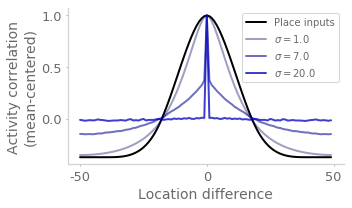

In [9]:
figsize=(5,3)
plt.figure(figsize=figsize)
corr_func = pairwise_cos_sim_centered

plt.plot(
    cross_corr_from_pairwise(corr_func(np.clip(place_inputs, 0, np.inf))),
    color="black", label="Place inputs", linewidth=2.)

for i, r in enumerate(rec_strength_options):
    acts = all_acts[i]
    plt.plot(cross_corr_from_pairwise(corr_func(acts)), 
            color=[0, 0, 1.5*(float(i)+2)/8, 1.5*(float(i)+2)/8],
             label=f"$\sigma=$"+str(r), linewidth=2.)
plt.legend(fontsize=10)
plt.xticks(np.arange(0, num_states+1, 50), np.arange(0, num_states+1, 50)-num_states//2)
plt.xlabel("Location difference")
plt.ylabel("Activity correlation\n(mean-centered)")
plt.tight_layout()
plt.savefig('barcode_decorrelating.png', dpi=300)

# Plot recurrent v FF

Text(0, 0.5, 'Activity correlation\n(mean-centered)')

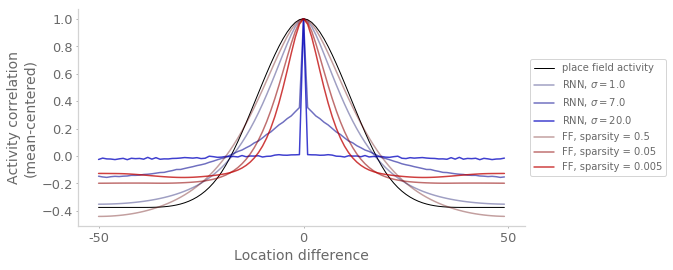

In [35]:
figsize=(10,4)
plt.figure(figsize=figsize)
corr_func = pairwise_cos_sim_centered

plt.plot(cross_corr_from_pairwise(corr_func(np.clip(place_inputs, 0, np.inf))), color="black", label="place field activity")

for i, r in enumerate(rec_strength_options):
    acts = all_acts[i]
    plt.plot(cross_corr_from_pairwise(corr_func(acts)), 
            color=[0, 0, 1.5*(float(i)+2)/8, 1.5*(float(i)+2)/8],
             label=f"RNN, $\sigma=$"+str(r), linewidth=1.5)
for i, s in enumerate(sparsity_options):
    plt.plot(cross_corr_from_pairwise(corr_func(ff_barcodes[i])),
            color=[1.5*(float(i)+2)/8, 0, 0, 1.5*(float(i)+2)/8],
             label="FF, sparsity = "+str(s), linewidth=1.5)
    
# Put a legend to the right of the current axis
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.xticks(np.arange(0, num_states+1, 50), np.arange(0, num_states+1, 50)-num_states//2)
plt.xlabel("Location difference")
plt.ylabel("Activity correlation\n(mean-centered)")

# Plot example FF barcodes

In [54]:
example_ff = ff_barcodes[-1] # (states, neurons)

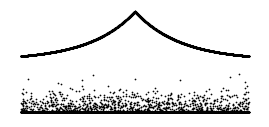

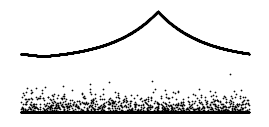

In [55]:
for s in [50, 60]:
    fig, axs = plt.subplots(2, 1, figsize=(4.5,2))
    axs[0].scatter(
        np.arange(N_bar), place_inputs[s],
        color='black', s=0.5
        )
    axs[1].scatter(
        np.arange(N_bar), example_ff[s],
        color='black', s=0.5
        )
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    plt.show()

In [56]:
example_ff = ff_barcodes[0] # (states, neurons)

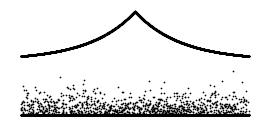

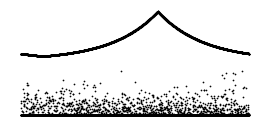

In [57]:
for s in [50, 60]:
    fig, axs = plt.subplots(2, 1, figsize=(4.5,2))
    axs[0].scatter(
        np.arange(N_bar), place_inputs[s],
        color='black', s=0.5
        )
    axs[1].scatter(
        np.arange(N_bar), example_ff[s],
        color='black', s=0.5
        )
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    plt.show()